## Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../02-regression/data/car_price.csv")

### 1. Data Prep

In [3]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [4]:
cat_vars = df.dtypes[df.dtypes == "object"].index

for c in cat_vars:
    df[c] = df[c].str.lower().str.replace(" ", "_")

In [5]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

In [6]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [7]:
df["age"] = 2017 - df["year"]

In [8]:
df["engine_hp"] = df.engine_hp.fillna(df.engine_hp.mean())
df["engine_cylinders"] = df.engine_cylinders.fillna(df.engine_cylinders.mean())
df["number_of_doors"] = df.number_of_doors.fillna(0)

In [9]:
df["engine_fuel_type"] = df.engine_fuel_type.fillna("unknown")
df["market_category"] = df.market_category.fillna("unknown")

### 2. Validation Framework

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=3)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=3)

In [12]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.msrp.values
y_val = df_val.msrp.values
y_test = df_test.msrp.values

del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

### 3. EDA

In [15]:
import seaborn as sns
%matplotlib inline

<Axes: xlabel='msrp', ylabel='Count'>

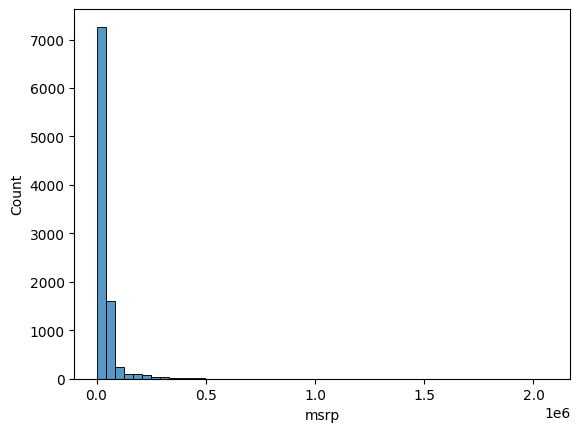

In [16]:
sns.histplot(df_full_train.msrp, bins=50)

<Axes: xlabel='msrp', ylabel='Count'>

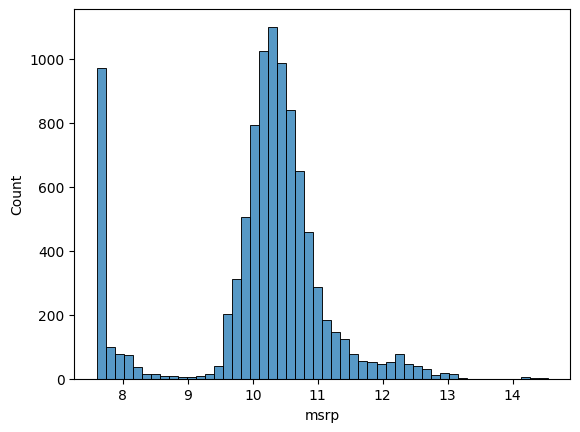

In [17]:
sns.histplot(np.log1p(df_full_train.msrp), bins=50)

In [18]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

In [19]:
df_full_train.dtypes.index

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp', 'age'],
      dtype='object')

In [20]:
num_vars = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity", "age"]

cat_vars = ['make', 'model', 'year', 'engine_fuel_type', 'transmission_type', 'driven_wheels',
               'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style']

In [21]:
df_full_train[cat_vars].nunique()

make                  48
model                900
year                  28
engine_fuel_type      11
transmission_type      5
driven_wheels          4
number_of_doors        4
market_category       70
vehicle_size           3
vehicle_style         16
dtype: int64

### 4. Correlation

In [22]:
df_full_train[num_vars].corrwith(df_full_train.msrp)

engine_hp           0.652100
engine_cylinders    0.521307
highway_mpg        -0.152381
city_mpg           -0.153335
popularity         -0.046357
age                -0.218468
dtype: float64

### 5. One-hot Encoding

In [23]:
from sklearn.feature_extraction import DictVectorizer

In [24]:
dv = DictVectorizer(sparse=False)
dict_train = df_train[cat_vars + num_vars].to_dict(orient="records")
X_train = dv.fit_transform(dict_train)

dict_val = df_val[cat_vars + num_vars].to_dict(orient="records")
X_val = dv.transform(dict_val)

### 6. Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
lrmodel = LinearRegression()
lrmodel.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [27]:
lrmodel.intercept_

np.float64(-32.05043372452789)

In [28]:
lrmodel.coef_.round(3)

array([-0.021, -0.004,  0.016, ..., -0.047,  0.003,  0.021], shape=(1040,))

In [50]:
y_pred_lr = lrmodel.predict(X_val)

In [51]:
np.expm1(y_pred_lr)

array([ 25072.12867846, 196403.03797516,  27458.92093181, ...,
        43315.04663857,  18827.95567102,  26204.90844929], shape=(2383,))

### 7. Ridge Regression

In [31]:
from sklearn.linear_model import Ridge

In [32]:
rrmodel = Ridge(alpha=0.1)
rrmodel.fit(X_train, y_train)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [33]:
rrmodel.intercept_

np.float64(-64.57392377104392)

In [34]:
rrmodel.coef_.round(3)

array([-0.037, -0.006,  0.009, ..., -0.057,  0.018,  0.037], shape=(1040,))

In [47]:
y_pred_rr = rrmodel.predict(X_val)

In [48]:
np.expm1(y_pred_rr)

array([ 26063.77366876, 214452.19922466,  26832.87105706, ...,
        43759.10904899,  18747.99036148,  26306.54099329], shape=(2383,))

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {"alpha": np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_["alpha"]
best_alpha

np.float64(0.1)

### 8. RMSE

In [38]:
from sklearn.metrics import root_mean_squared_error

In [54]:
rmse = root_mean_squared_error(y_val, y_pred_lr)
display("Linear Regression:", rmse)

'Linear Regression:'

0.22791659686378862

In [55]:
rmse = root_mean_squared_error(y_val, y_pred_rr)
display("Ridge:", rmse)

'Ridge:'

0.22124811135066963

### 9. Using the Model

In [41]:
dict_full_train = df_full_train[num_vars + cat_vars].to_dict(orient="records")

In [57]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
y_full_train = np.log1p(df_full_train.msrp.values)

In [58]:
dict_test = df_test[num_vars + cat_vars].to_dict(orient="records")
X_test = dv.transform(dict_test)

In [59]:
model = Ridge(alpha=0.1)
model.fit(X_full_train, y_full_train)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [60]:
y_pred = model.predict(X_test)

In [62]:
np.expm1(y_pred)

array([ 2568.4952199 ,  1870.65035486,  2132.9021367 , ...,
       33754.51888526, 69256.84085194, 70009.87278646], shape=(2383,))

In [63]:
root_mean_squared_error(y_test, y_pred)

0.18473263588927033

In [64]:
car = dict_test[21]
car

{'engine_hp': 192.0,
 'engine_cylinders': 4.0,
 'highway_mpg': 46,
 'city_mpg': 39,
 'popularity': 1720,
 'age': 0,
 'make': 'kia',
 'model': 'optima_hybrid',
 'year': 2017,
 'engine_fuel_type': 'regular_unleaded',
 'transmission_type': 'automatic',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'hybrid',
 'vehicle_size': 'midsize',
 'vehicle_style': 'sedan'}

In [68]:
X_car = dv.transform(car)
y_pred_car = model.predict(X_car)
np.expm1(y_pred_car)[0], np.expm1(y_test[21])

(np.float64(31200.62916762077), np.float64(25995.00000000002))